In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

titanic = pd.read_csv('./titanic/train.csv')
train, test = train_test_split(titanic, test_size=0.2, random_state=39)

In [3]:
# cabinの分割
from sklearn.base import BaseEstimator, TransformerMixin

def split_cabins(cabins):
  _floors = []
  _numbers = []

  for cabin in cabins.astype(str):
    if cabin == 'nan' or not cabin:
      _floors.append(np.nan)
      _numbers.append(np.nan)
      continue
    else:
      _first_cabin = cabin.split(" ")[0]
      floor = _first_cabin[0]
      number = _first_cabin[1:]
      _floors.append(floor)
      _numbers.append(number if number else np.nan)

  return _floors, np.array(_numbers, dtype=np.float64)

class CabinConverter(BaseEstimator, TransformerMixin):

  def __init__(self, cabin_ix = 0, omit_floor_number=False):
    self.cabin_ix = cabin_ix
    self.omit_floor_number = omit_floor_number
    return

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    cabins = X["Cabin"].values
    floors, numbers = split_cabins(cabins)
    _X = X.drop("Cabin", axis=1)
    if self.omit_floor_number:
      return _X.assign(Floor=floors)
    else:
      return _X.assign(Floor=floors, CabinNumber=numbers)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class BabyAppender(BaseEstimator, TransformerMixin):

  def __init__(self, limit=5):
    self.limit = limit 
    return

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X.assign(Baby=X["Age"] <= self.limit)

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class AgeFilter(BaseEstimator, TransformerMixin):

  def __init__(self, top=80, bottom=0):
    self.top = top
    self.bottom = bottom
    return

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X[(X["Age"] < self.top) & (X["Age"] > self.bottom)]

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class FareFilter(BaseEstimator, TransformerMixin):

  def __init__(self, top=200, bottom=0):
    self.top = top
    self.bottom = bottom
    return

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X[(X["Fare"] < self.top) & (X["Fare"] > self.bottom)]

## グループの人数を特徴量化

In [9]:
titanic[["Parch", "SibSp"]]

,Parch,SibSp
0,0,1
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
886,0,0
887,0,0
888,2,1
889,0,0


In [7]:
titanic["Parch"] + titanic["SibSp"]

0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    3
889    0
890    0
Length: 891, dtype: int64

array([[<AxesSubplot:title={'center':'Group'}>]], dtype=object)

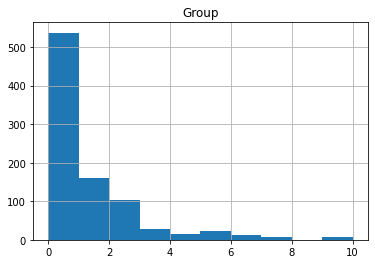

In [10]:
_titanic = titanic.assign(Group=titanic["Parch"] + titanic["SibSp"])
_titanic[["Group"]].hist()

<AxesSubplot:xlabel='Survived', ylabel='Group'>

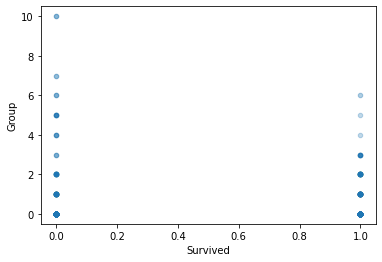

In [11]:
_titanic.plot(kind="scatter", x="Survived", y="Group", alpha=0.1)

array([[<AxesSubplot:title={'center':'Group'}>]], dtype=object)

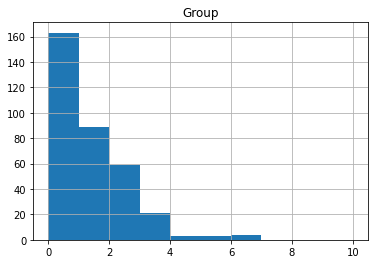

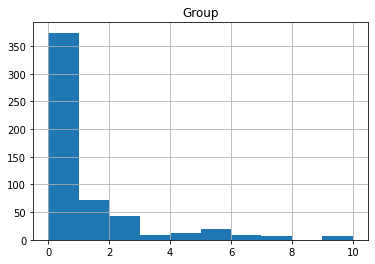

In [13]:
_titanic.query("Survived == 1")[["Group"]].hist(range=(0,10), bins=10)
_titanic.query("Survived != 1")[["Group"]].hist(range=(0,10), bins=10)

In [19]:
len(_titanic[["Group"]]),len(_titanic[["Group"]].dropna()) 

(891, 891)

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class GroupNumberAppender(BaseEstimator, TransformerMixin):

  def __init__(self):
    return

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X.assign(Group=X["Parch"] + X["SibSp"])

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

cabins = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', np.nan]

dataframe_pipeline = Pipeline([
  ('baby', BabyAppender()),
  ('cabin', CabinConverter()),
  ('group', GroupNumberAppender()),
])

scaler_pipeline = Pipeline([
  ('imputer', SimpleImputer()),
  ('std_scaler', StandardScaler()),
])

col_transformer = ColumnTransformer([ 
  ("num", SimpleImputer(strategy="median"), ["Pclass", "Age", "Fare"]),
  ("sex", OneHotEncoder(), ["Pclass", "Sex"]),
  ("floor", OneHotEncoder(categories=[cabins]), ["Floor"]),
  ("passthrough", "passthrough", ["Baby", "Group"])
])

whole_pipeline = Pipeline([
  ('dataframe', dataframe_pipeline),
  ('std_scaler', col_transformer),
])

In [22]:
filter = Pipeline([
  ("age", AgeFilter()),
  # ("fare", FareFilter()),
])
_train = filter.fit_transform(train)

y_train = _train["Survived"]
X_train = _train.drop("Survived", axis=1)

y_test = test["Survived"]
X_test = test.drop("Survived", axis=1)

In [23]:
_X_train = whole_pipeline.fit_transform(X_train)
clf = RandomForestClassifier(random_state=38)
clf.fit(_X_train, y_train)
cross_val_score(clf, _X_train, y_train, cv=3, scoring="accuracy")

array([0.80628272, 0.75789474, 0.82105263])

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  { 
    "criterion": ["gini", "entropy"],
    "class_weight": ["balanced"],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [3,4,5,6],
    "n_estimators": [50, 100, 150],
  }
]

grid_search = GridSearchCV(
  RandomForestClassifier(random_state=38),
  param_grid,
  cv=5,
  scoring="accuracy",
  return_train_score=True)
grid_search.fit(_X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=38),
             param_grid=[{'class_weight': ['balanced'],
                          'criterion': ['gini', 'entropy'],
                          'max_features': ['sqrt', 'log2'],
                          'min_samples_split': [3, 4, 5, 6],
                          'n_estimators': [50, 100, 150]}],
             return_train_score=True, scoring='accuracy')

In [25]:
grid_search.best_score_, grid_search.best_params_

(0.828421052631579,
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_features': 'sqrt',
  'min_samples_split': 4,
  'n_estimators': 100})

In [26]:
_X_test = whole_pipeline.fit_transform(X_test)
cross_val_score(grid_search.best_estimator_, _X_test, y_test, cv=3, scoring="accuracy")

array([0.8       , 0.8       , 0.79661017])

In [27]:
titanic_test = pd.read_csv('./titanic/test.csv')

In [28]:
_titanic_test = whole_pipeline.fit_transform(titanic_test)
predict = grid_search.best_estimator_.predict(_titanic_test)

id = np.array(titanic_test["PassengerId"]).astype(int)
df = pd.DataFrame(predict, id, columns = ["Survived"])
df.to_csv("./titanic/predict-5.csv", index_label = ["PassengerId"])